In [1]:
# 코드 11-1 라이브러리 호출
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 앞서 설치한 opencv-python 라이브러리를 호출
from sklearn.metrics import (
    silhouette_score,
)
import os, glob, shutil

2024-12-03 02:38:10.583629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733161090.593556  273559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733161090.596527  273559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:38:10.607345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 코드 11-2 GPU 설정
# cuDNN 초기화에 문제가 있을 때 실행
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # GPU가 두 개 이상이라면 메모리를 균등하게 사용하도록 조정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        # 물리적 GPU와 논리적 GPU의 수량을 표기
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733161092.329583  273559 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1


In [3]:
# 코드 11-3 데이터셋 준비
import cv2

input_dir = "data/pets"
glob_dir = input_dir + "/*.jpg"

images = [cv2.resize(cv2.imread(file), (224, 224)) for file in glob.glob(glob_dir)]
paths = [file for file in glob.glob(glob_dir)]
images = np.array(np.float32(images).reshape(len(images), -1) / 255)

In [4]:
# 코드 11-4 특성 추출
model = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

I0000 00:00:1733161094.331861  273641 service.cc:148] XLA service 0x7f260430f380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733161094.331898  273641 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-12-03 02:38:14.352107: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733161094.555103  273641 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

I0000 00:00:1733161097.545823  273641 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


In [8]:
# 코드 11-5 클러스터링 구성
k = 2  # 클래스는 개와 고양이 두 개
kmodel = KMeans(n_clusters=k, random_state=728)
kmodel.fit(pred_images)  # 모델 훈련
kpredictions = kmodel.predict(pred_images)  # 모델 예측
shutil.rmtree("data/output")  # 모델이 분류될 폴더의 위치 지정
for i in range(k):
    # 모델이 분류될 폴더를 생성(output0, output1이 생성)
    os.makedirs("data/output" + str(i))
for i in range(len(paths)):
    # pets 폴더의 이미지들이 output0과 output1로 복사되면서 클래스에 적합하게 분류
    shutil.copy2(paths[i], "data/output" + str(kpredictions[i]))

In [9]:
# 코드 11-6 KMeans에서 클래스 개수 알아보기
sil = []
kl = []
kmax = 10
for k in range(2, kmax + 1):
    kmeans2 = KMeans(n_clusters=k).fit(pred_images)
    labels = kmeans2.labels_
    # 실루엣 방법을 이용한 클래스 개수 확인
    sil.append(silhouette_score(pred_images, labels, metric="euclidean"))
    kl.append(k)

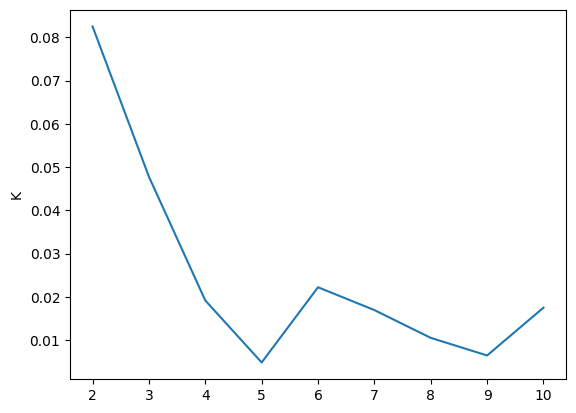

In [10]:
# 코드 11-7 실루엣의 시각화
plt.plot(kl, sil)
plt.ylabel("Silhoutte Score")
plt.ylabel("K")
plt.show()